In [1]:
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from diebold_mariano import diebold_mariano_test

In [2]:
from utils import *

DEVICE:  cpu


In [3]:
T=30

In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

# Set consistent style for publication-quality plots
sns.set(style="whitegrid", context="talk", palette="colorblind")
matplotlib.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.frameon": True,
    "axes.titleweight": "bold"
})

def customize_ax(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, fontsize=18, fontweight="bold")
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if ax.get_legend():
        ax.legend(fontsize=12, frameon=True)

# Insert your original loop code here afterward, using customize_ax() and matplotlib.rcParams updates
# on all relevant plots to ensure publication-quality formatting.


In [5]:
etfs = ['XLB','XLE','XLF','XLI','XLK','XLP','XLV','XLY','XLU']
metric2 = "SD_Squared_Returns"
metric3 = "SD_Prices"
metric4 = "IQR"
metrics = ["ATR",metric2,metric3,metric4]
# start = '2001-01-01'
# end = '2020-01-01'
# start_t = '2022-01-02'
# end_t = '2024-01-05'
date_list = [['2001-01-01', '2020-01-01', '2022-01-02', '2024-01-05'], ['1990-01-05', '2010-01-05', '2023-01-05', '2024-01-05'], ['2000-01-05', "2024-01-05", "2024-01-05", "2025-01-05"], ['2005-01-05', '2010-01-05', '2020-01-05', '2024-01-05']]
starts,ends = np.array([(f'200{i}-01-01',f'200{i+12}-01-01') for i in range(0,12,4)]).T
models = {}
lrs = [0]
h1 = 50
h2 = 50
hl1s = [20,50,70,100]
hl1s = [20,50,70,100]
models = ["LSTM","RNN"]
b_types = ['ATR' ,'STD']
lr = 0
feat_combos = [['Open','Close','High','Low','Volume','Return','Short_MA','Long_MA'],['Open','Close','High','Low','Volume'],['index','Open','Close','High','Low','Volume']]

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 30th day, Bought 5.9283851078966086 shares for $500.0
On the 44th day, Bought 4 shares for $342.32
On the 45th day, Bought 1 shares for $86.1
On the 46th day, Bought 0 shares for $0.0
On the 47th day, Bought 0 shares for $0.0
On the 48th day, Bought 0 shares for $0.0
On the 49th day, Bought 0 shares for $0.0
On the 50th day, Bought 0 shares for $0.0
On the 51th day, Bought 0 shares for $0.0
On the 52th day, Bought 0 shares for $0.0
On the 53th day, Bought 0 shares for $0.0
On the 54th day, Bought 0 shares for $0.0
On the 55th day, Bought 0 shares for $0.0
On the 72th day, sold 10.92838510789661 shares for $933.5026559165284
On the 134th day, Bought 6.599788806758183 shares for $500.0
On the 136th day, Bought 6.399590426212723 shares for $500.0
On the 144th day, Bought 0 shares for $0.0
On the 155th day, Bought 0 shares for $0.0
On the 159th day, sold 12.999379232970906 shares for $980.2831879583359
On the 189th day, Bought 7.086167800453

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 30th day, Bought 5.9283851078966086 shares for $500.0
On the 44th day, Bought 4 shares for $342.32
On the 45th day, Bought 1 shares for $86.1
On the 46th day, Bought 0 shares for $0.0
On the 47th day, Bought 0 shares for $0.0
On the 48th day, Bought 0 shares for $0.0
On the 49th day, Bought 0 shares for $0.0
On the 50th day, Bought 0 shares for $0.0
On the 51th day, Bought 0 shares for $0.0
On the 73th day, sold 10.92838510789661 shares for $948.2559758121888
On the 136th day, Bought 6.399590426212723 shares for $500.0
On the 144th day, Bought 6.30119722747322 shares for $499.99999999999994
On the 157th day, sold 12.700787653685943 shares for $985.8351376791029
On the 217th day, Bought 6.091617933723197 shares for $500.0
On the 218th day, Bought 6.067961165048543 shares for $500.0
On the 219th day, Bought 0 shares for $0.0
On the 220th day, Bought 0 shares for $0.0
On the 248th day, sold 12.15957909877174 shares for $983.4667575086582
On

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 56th day, Bought 5.611672278338945 shares for $500.0
On the 57th day, Bought 4 shares for $353.56
On the 58th day, Bought 1 shares for $87.37
On the 60th day, Bought 0 shares for $0.0
On the 61th day, Bought 0 shares for $0.0
On the 62th day, Bought 0 shares for $0.0
On the 63th day, Bought 0 shares for $0.0
On the 71th day, sold 10.611672278338945 shares for $893.2905723905725
On the 144th day, Bought 6.30119722747322 shares for $499.99999999999994
On the 160th day, sold 6.30119722747322 shares for $468.93509766855703
On the 191th day, Bought 7.155123068116772 shares for $500.0
On the 192th day, Bought 5 shares for $356.25
On the 202th day, Bought 0 shares for $0.0
On the 204th day, Bought 0 shares for $0.0
On the 210th day, sold 12.155123068116772 shares for $987.6037492844878
On the 381th day, Bought 5.970149253731344 shares for $500.00000000000006
On the 382th day, Bought 5.951672419950006 shares for $500.0
On the 383th day, Bought 0

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 30th day, Bought 5.9283851078966086 shares for $500.0
On the 70th day, sold 5.9283851078966086 shares for $506.87692672516005
On the 143th day, Bought 6.480041472265423 shares for $500.0
On the 144th day, Bought 6.30119722747322 shares for $499.99999999999994
On the 145th day, Bought 0 shares for $0.0
On the 146th day, Bought 0 shares for $0.0
On the 147th day, Bought 0 shares for $0.0
On the 157th day, sold 12.781238699738644 shares for $992.0797478737136
On the 253th day, Bought 6.027727546714888 shares for $500.0
On the 254th day, Bought 5 shares for $408.9
On the 261th day, Bought 1 shares for $83.4
On the 262th day, Bought 0 shares for $0.0
On the 263th day, Bought 0 shares for $0.0
On the 264th day, Bought 0 shares for $0.0
On the 265th day, Bought 0 shares for $0.0
On the 285th day, Bought 0 shares for $0.0
On the 286th day, Bought 0 shares for $0.0
On the 290th day, sold 12.027727546714889 shares for $940.3277396021701
On the 378

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 100th day, Bought 5.430060816681147 shares for $500.0
On the 108th day, sold 5.430060816681147 shares for $399.05516941789745
On the 152th day, Bought 6.304375236414071 shares for $500.0
On the 153th day, Bought 4 shares for $328.68
On the 155th day, Bought 0 shares for $0.0
On the 156th day, Bought 0 shares for $0.0
On the 157th day, Bought 0 shares for $0.0
On the 163th day, sold 10.30437523641407 shares for $806.8325810112217
On the 197th day, Bought 5.718860802928056 shares for $499.99999999999994
On the 198th day, Bought 4 shares for $354.48
On the 199th day, Bought 0 shares for $0.0
On the 200th day, Bought 0 shares for $0.0
On the 201th day, Bought 0 shares for $0.0
On the 202th day, Bought 0 shares for $0.0
On the 225th day, Bought 0 shares for $0.0
On the 229th day, sold 9.718860802928056 shares for $803.5554111860918
On the 236th day, Bought 5.899705014749262 shares for $500.0
On the 237th day, Bought 3 shares for $259.08
On th

[*********************100%***********************]  1 of 1 completed

XLE Final Value: 798.8030494170481, Final Money: 45.857900762022126, Final Shares: 8.899008966493628
read  4779  lines of data for ticker:  XLE



[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 153th day, Bought 6.084945843981989 shares for $500.0
On the 178th day, sold 6.084945843981989 shares for $441.7670682730923
On the 198th day, Bought 5.6420672534416605 shares for $500.0
On the 199th day, Bought 4 shares for $355.76
On the 200th day, Bought 0 shares for $0.0
On the 201th day, Bought 0 shares for $0.0
On the 202th day, Bought 0 shares for $0.0
On the 203th day, Bought 0 shares for $0.0
On the 245th day, sold 9.64206725344166 shares for $813.6940555179417
On the 252th day, Bought 5.558643690939411 shares for $500.0
On the 253th day, Bought 4 shares for $360.56
On the 254th day, Bought 0 shares for $0.0
On the 296th day, sold 9.55864369093941 shares for $742.7066147859922
On the 315th day, Bought 5.800464037122969 shares for $500.0
On the 316th day, Bought 3 shares for $259.62
On the 317th day, Bought 0 shares for $0.0
On the 318th day, Bought 0 shares for $0.0
On the 319th day, Bought 0 shares for $0.0
On the 359th day, Bo

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 100th day, Bought 5.430060816681147 shares for $500.0
On the 106th day, sold 5.430060816681147 shares for $447.32841007819286
On the 165th day, Bought 6.20347394540943 shares for $500.0
On the 166th day, Bought 5 shares for $410.4
On the 175th day, sold 11.20347394540943 shares for $789.6208436724567
On the 220th day, Bought 5.595970900951316 shares for $500.0
On the 227th day, sold 5.595970900951316 shares for $476.329043088976
On the 468th day, Bought 5.911563017261764 shares for $499.99999999999994
On the 469th day, Bought 3 shares for $254.79000000000002
On the 472th day, Bought 0 shares for $0.0
XLE Final Value: 802.0956437301434, Final Money: 48.08829683962563, Final Shares: 8.911563017261763


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 147th day, Bought 6.498570314530803 shares for $500.0
On the 170th day, sold 6.498570314530803 shares for $509.7478554717962
On the 201th day, Bought 5.555555555555555 shares for $500.0
On the 202th day, Bought 5.502366017387477 shares for $500.00000000000006
On the 203th day, Bought 0 shares for $0.0
On the 204th day, Bought 0 shares for $0.0
On the 227th day, sold 11.057921572943032 shares for $941.250284288911
On the 255th day, Bought 5.580980020091528 shares for $500.0
On the 256th day, Bought 4 shares for $361.92
On the 257th day, Bought 0 shares for $0.0
On the 259th day, Bought 0 shares for $0.0
On the 260th day, Bought 0 shares for $0.0
On the 297th day, sold 9.580980020091527 shares for $770.2149838151579
On the 315th day, Bought 5.800464037122969 shares for $500.0
On the 317th day, Bought 4 shares for $344.96
On the 318th day, Bought 0 shares for $0.0
On the 348th day, sold 9.80046403712297 shares for $783.0570765661253
On the 

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLF


KeyboardInterrupt: 

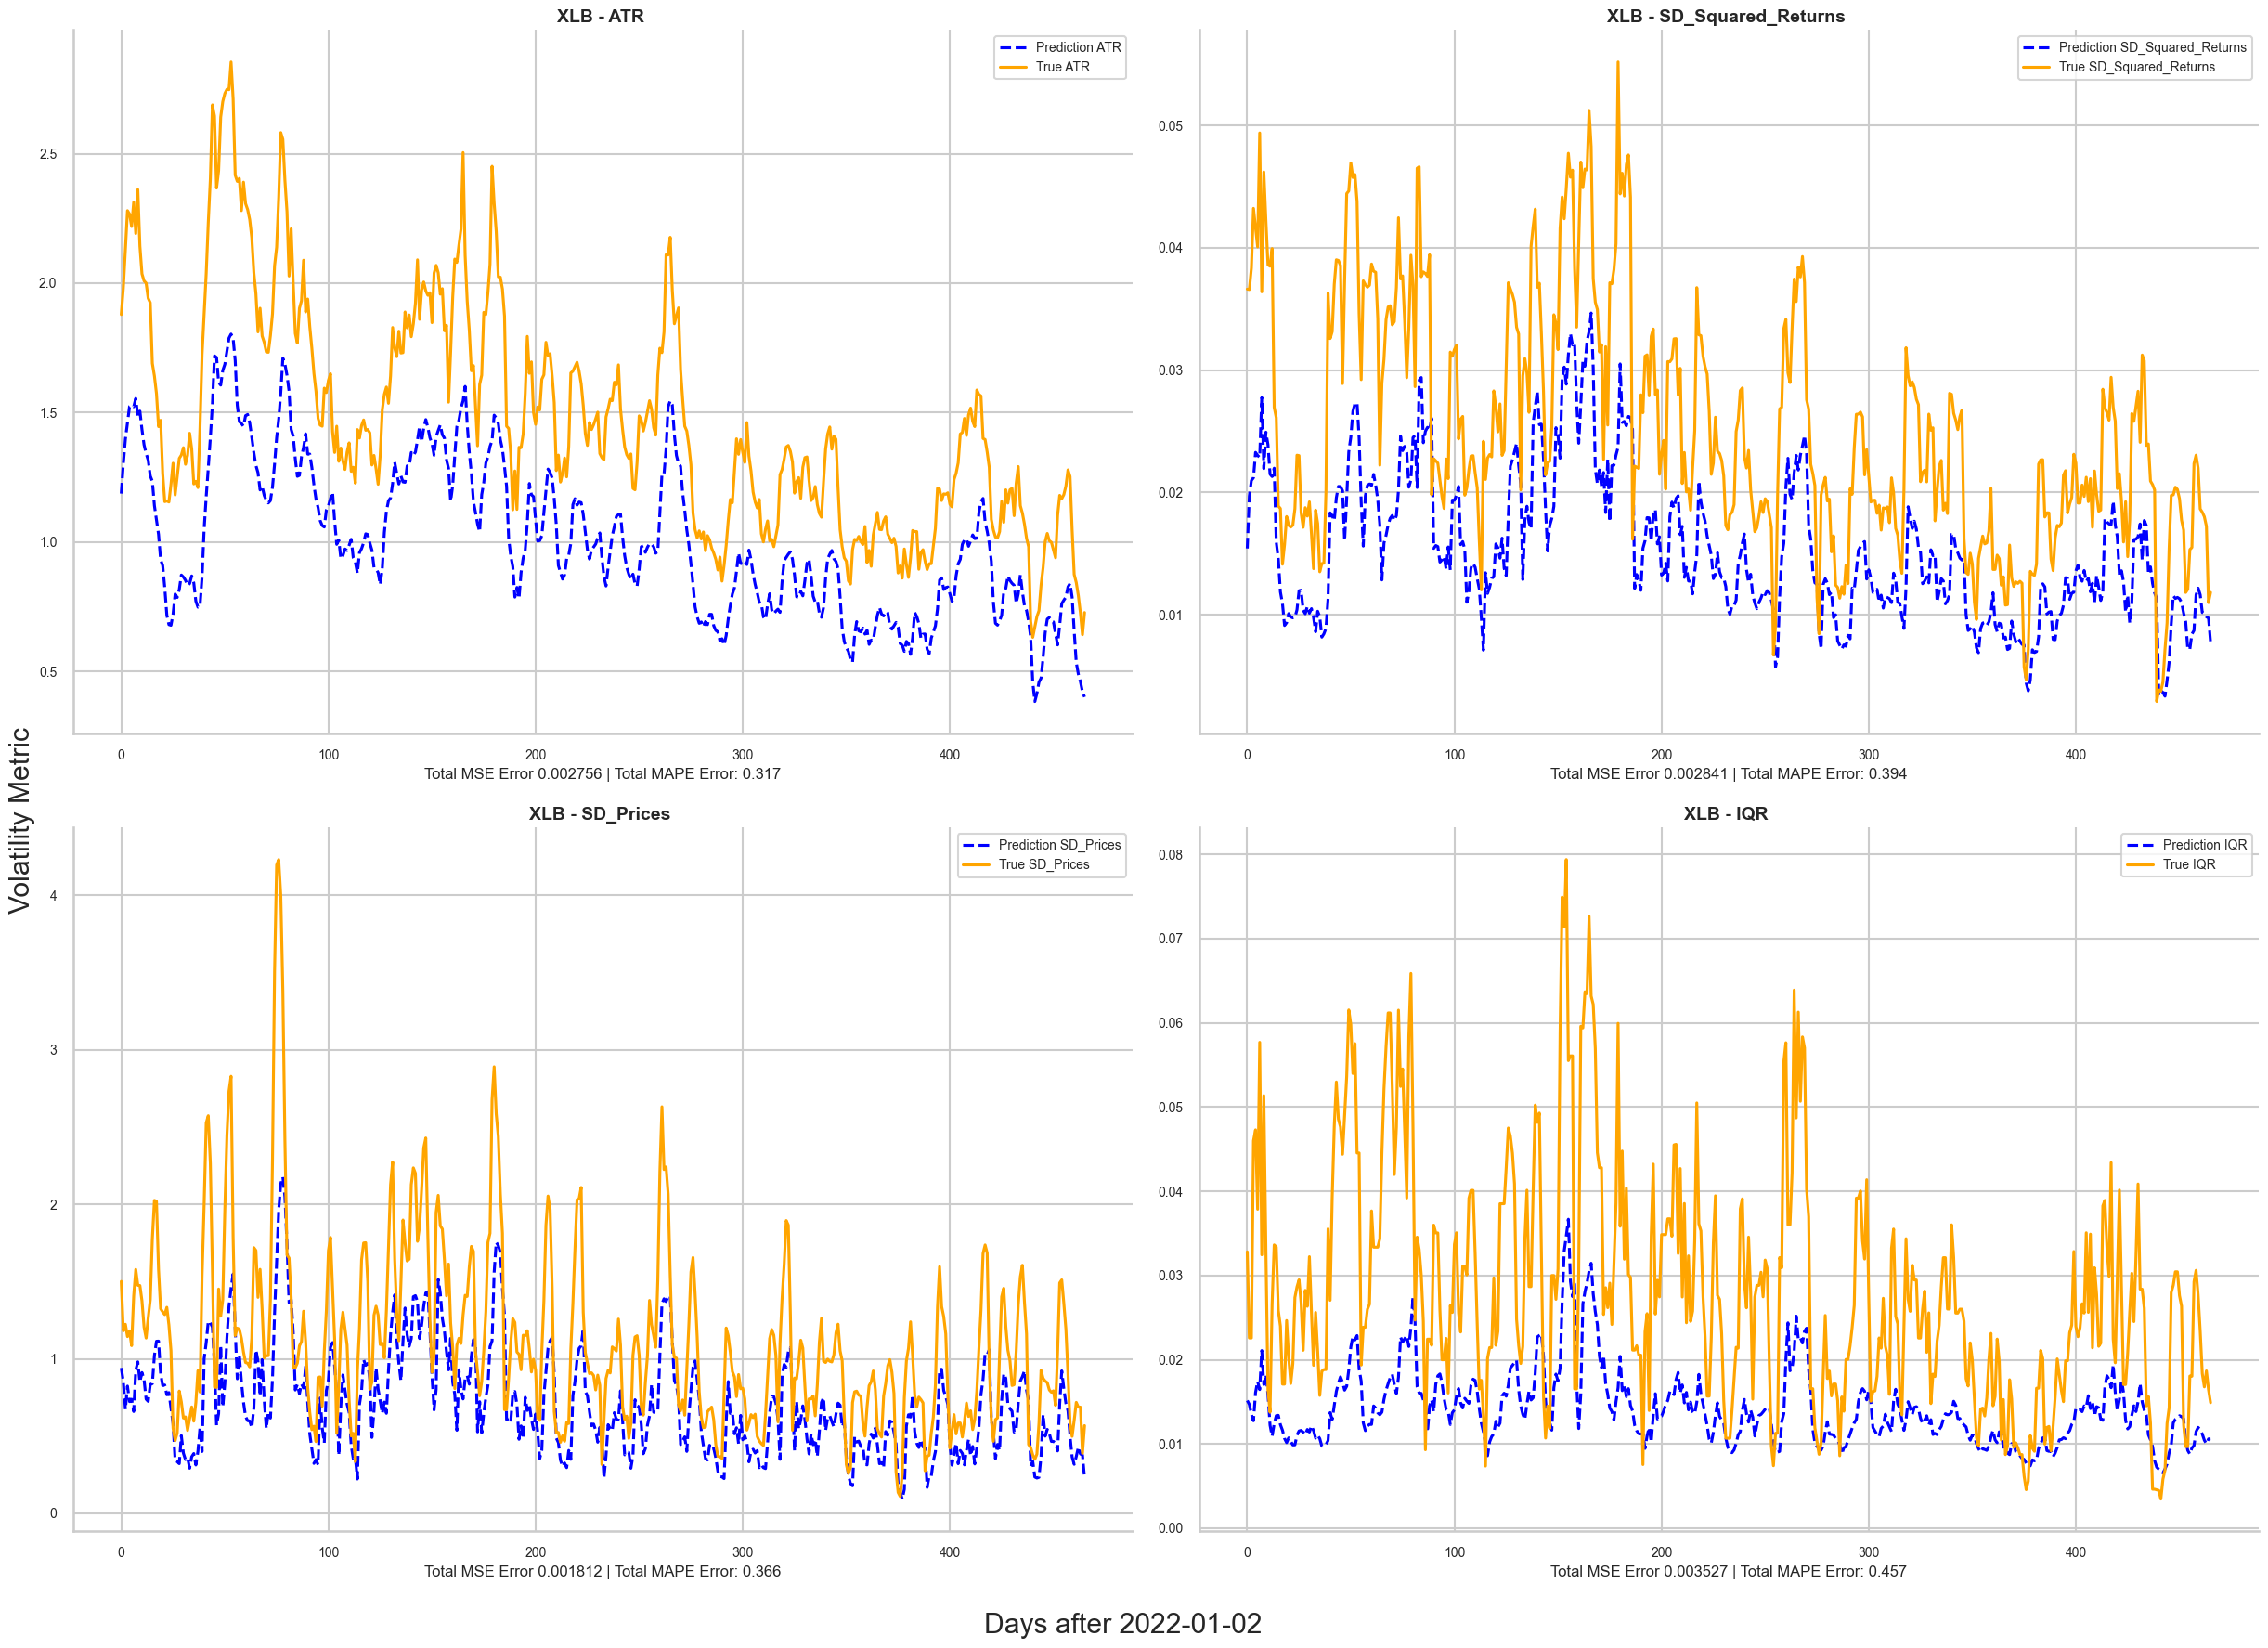

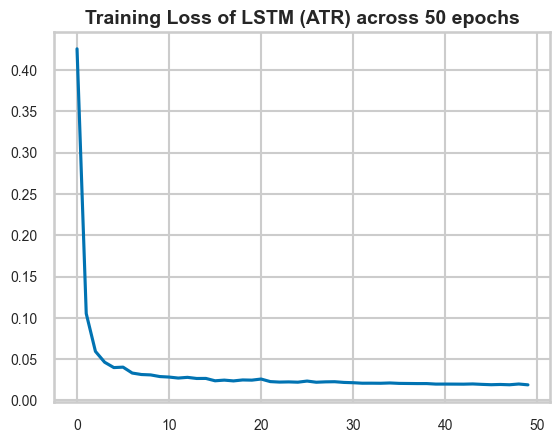

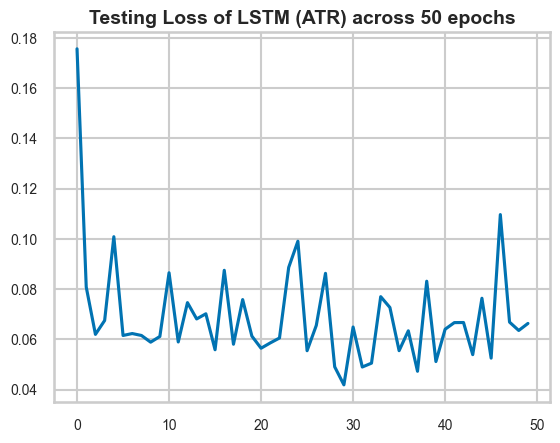

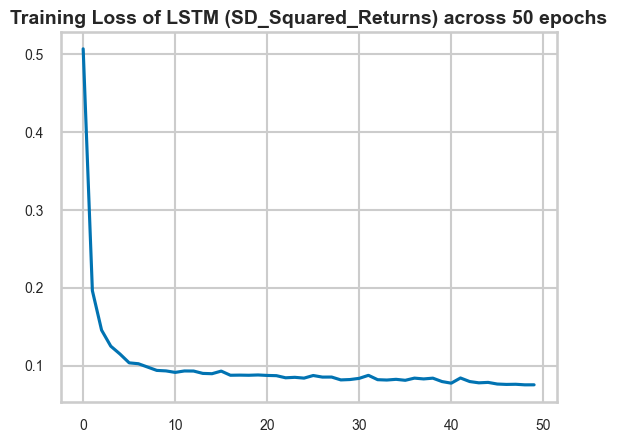

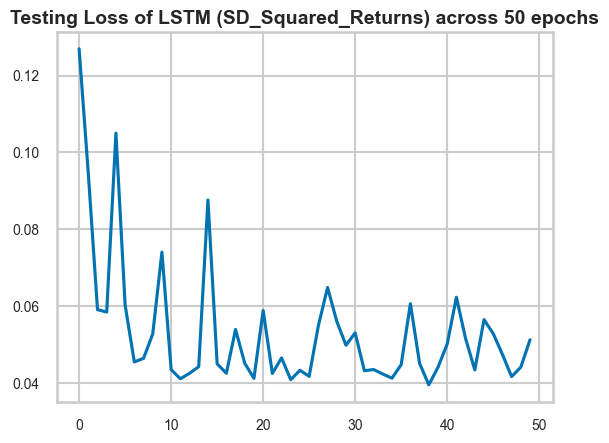

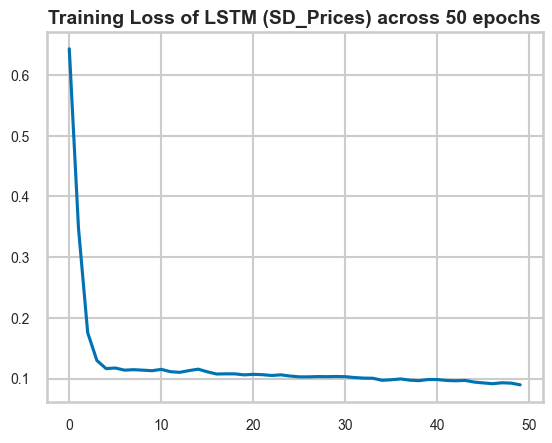

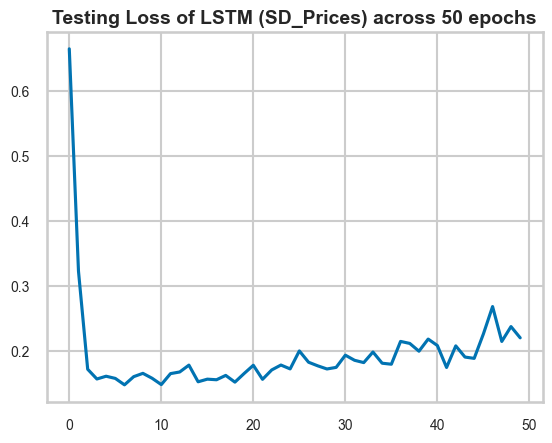

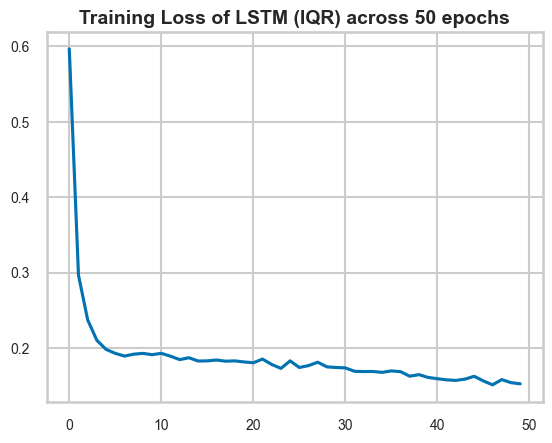

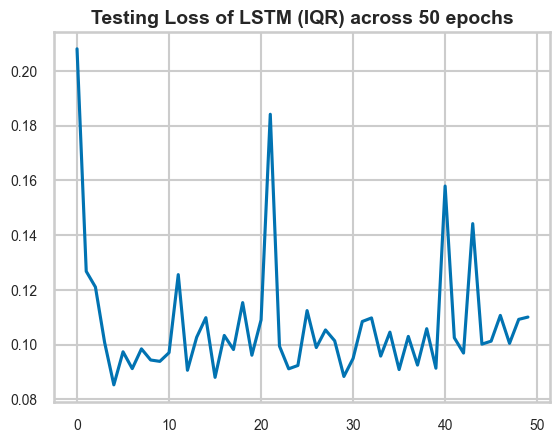

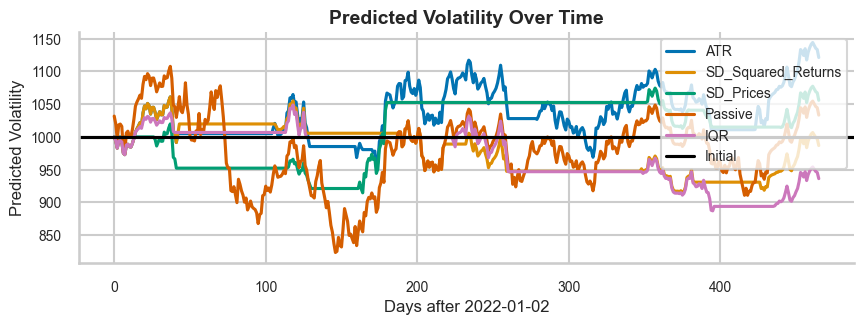

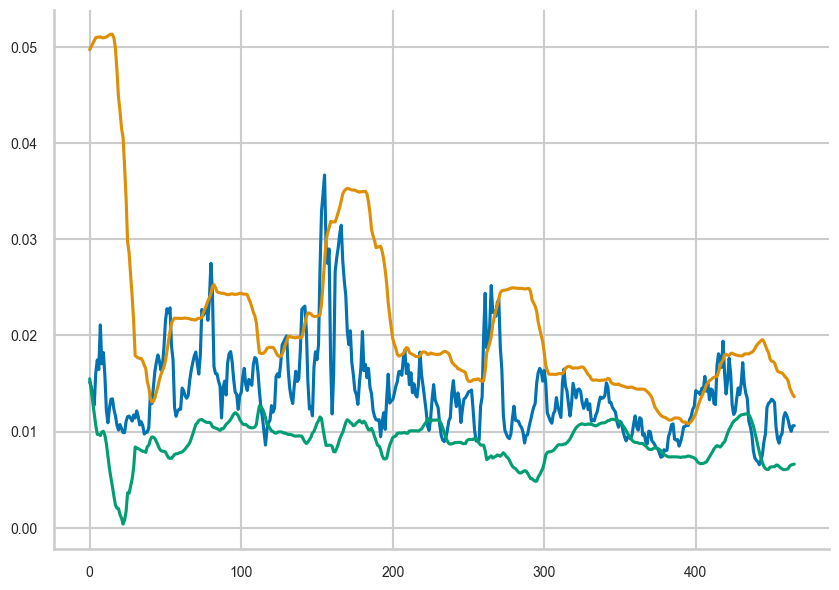

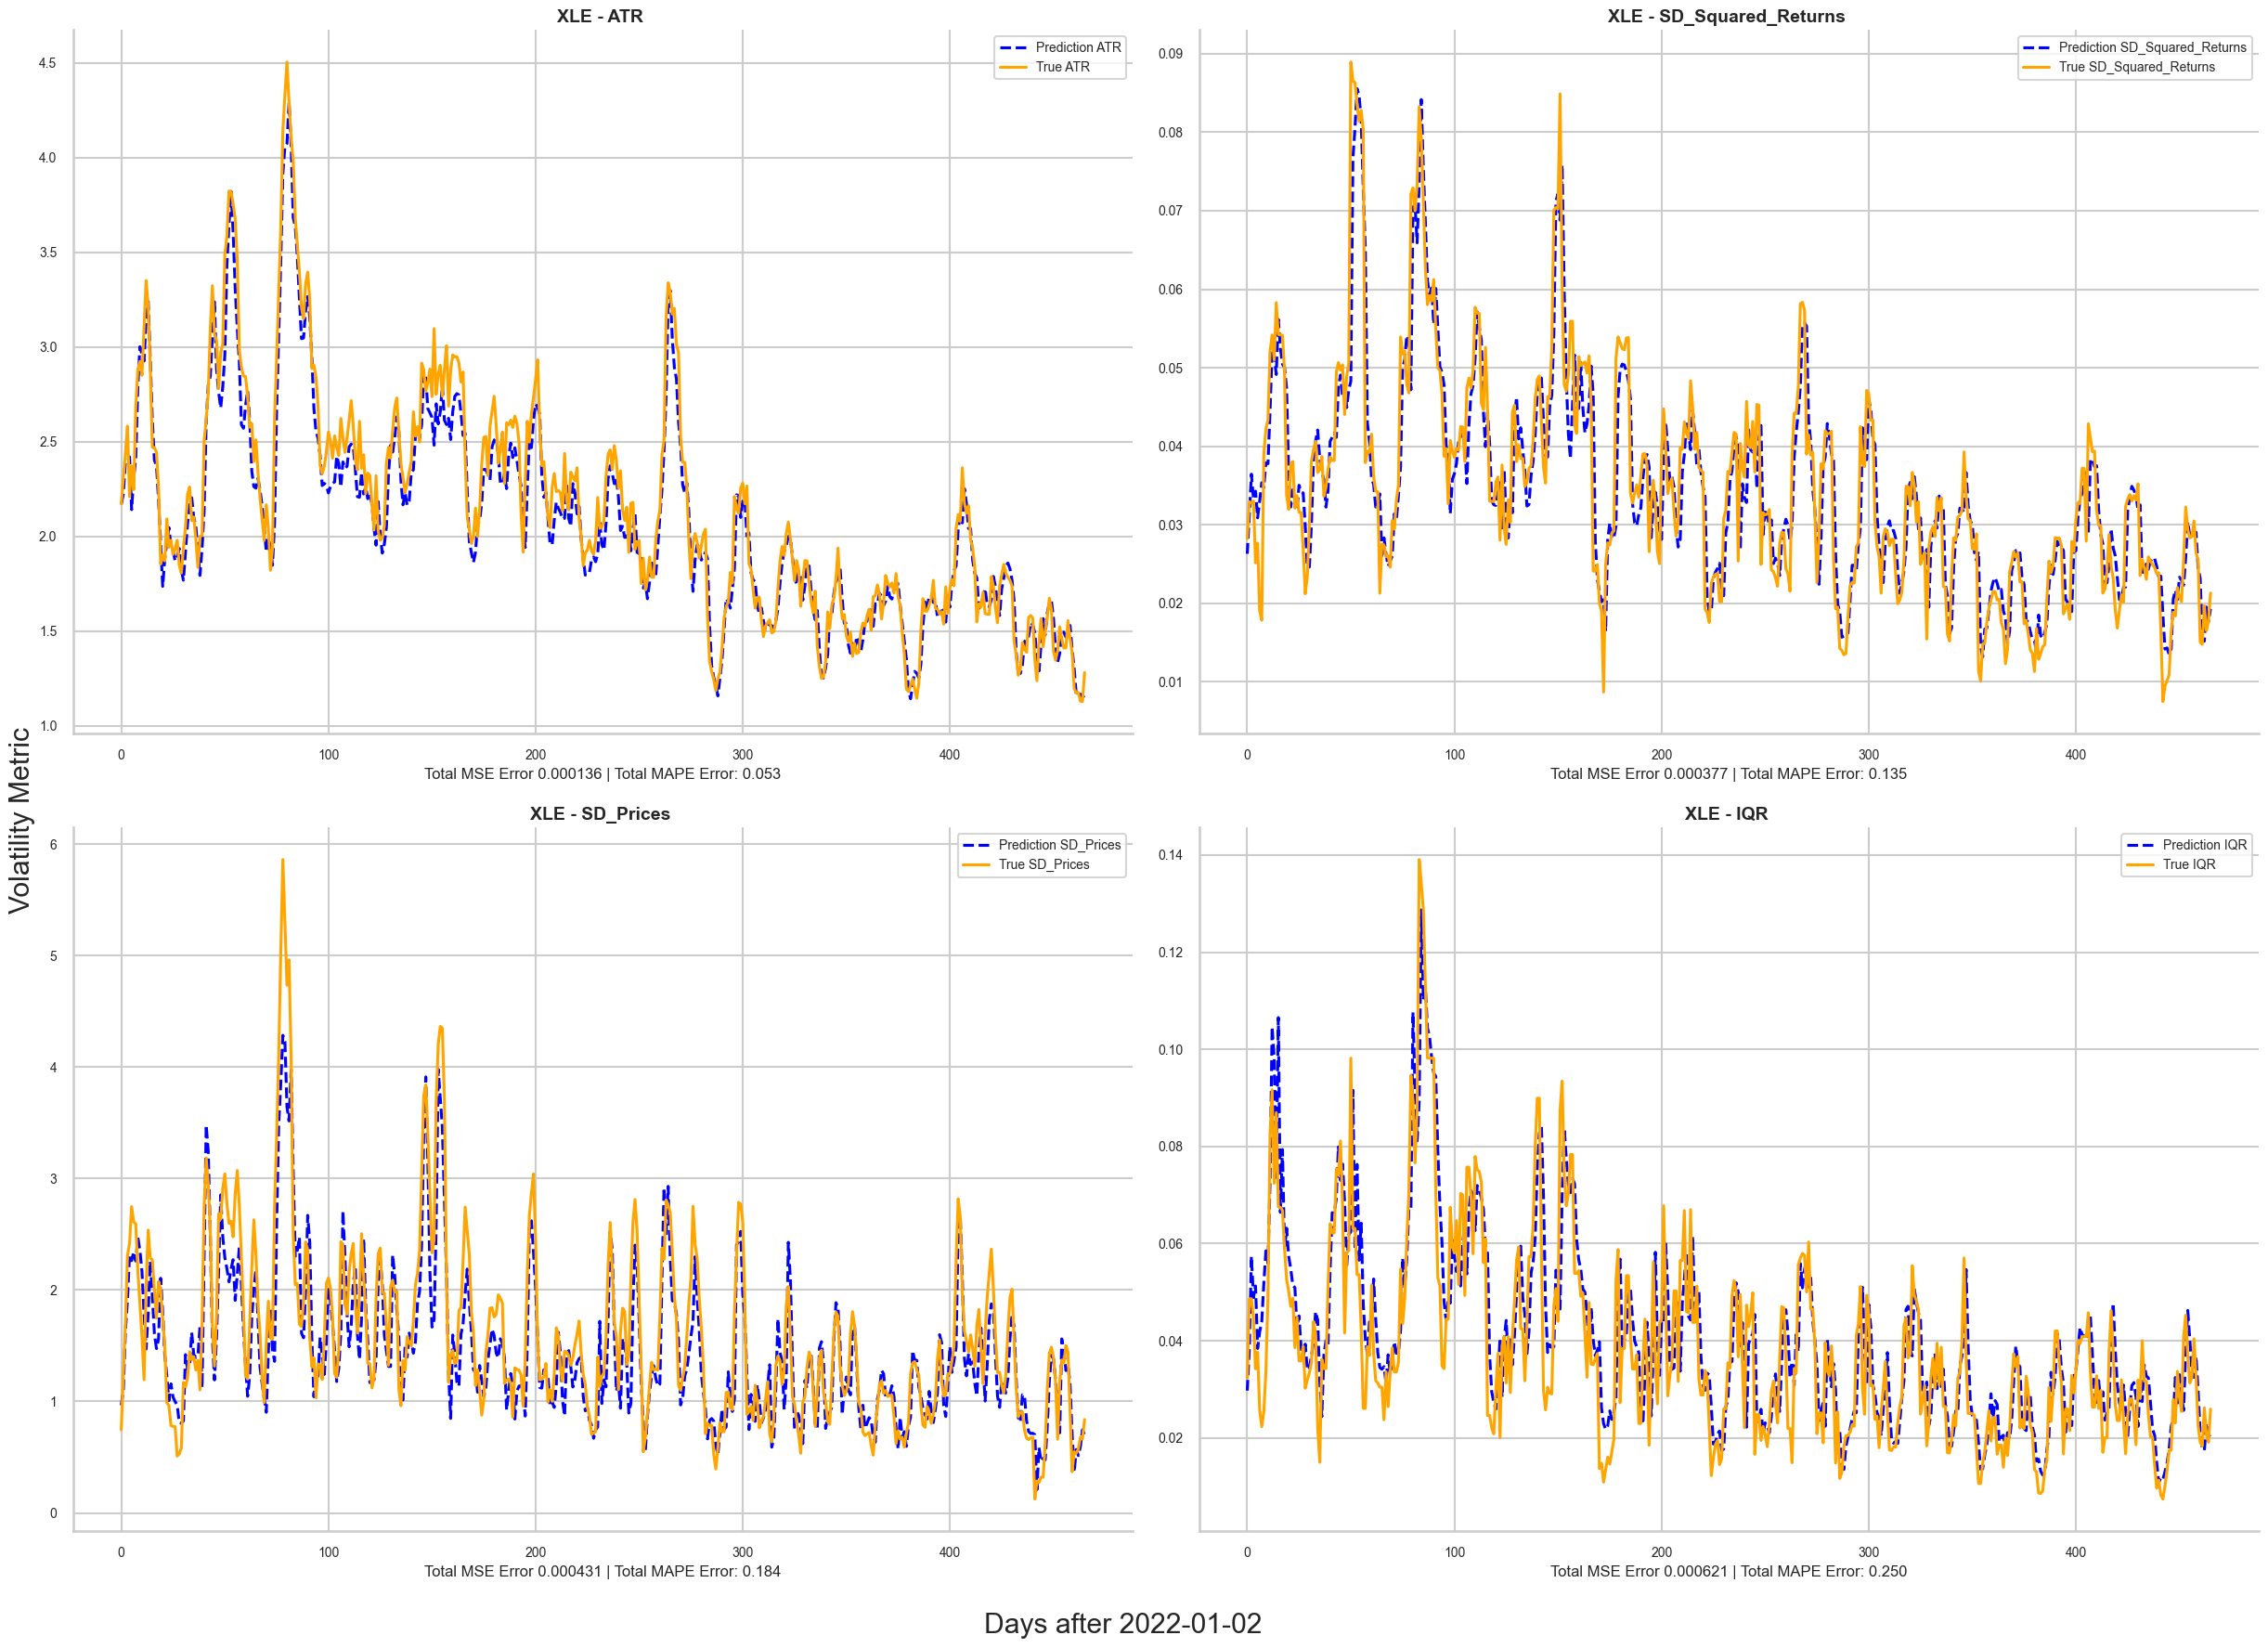

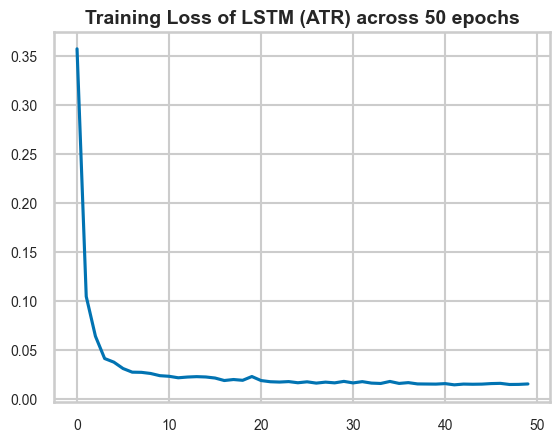

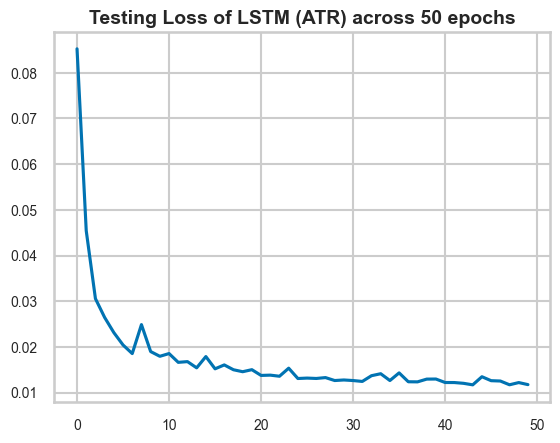

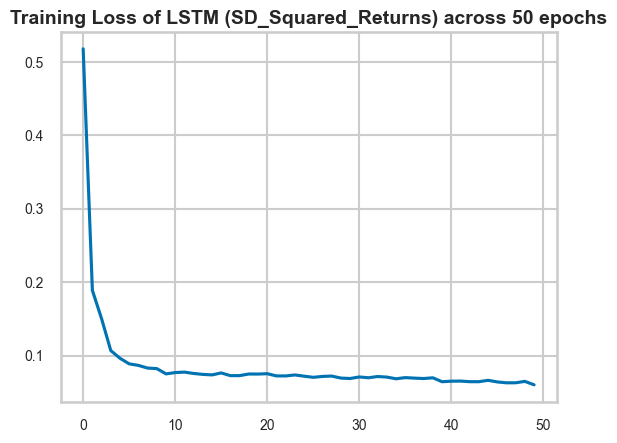

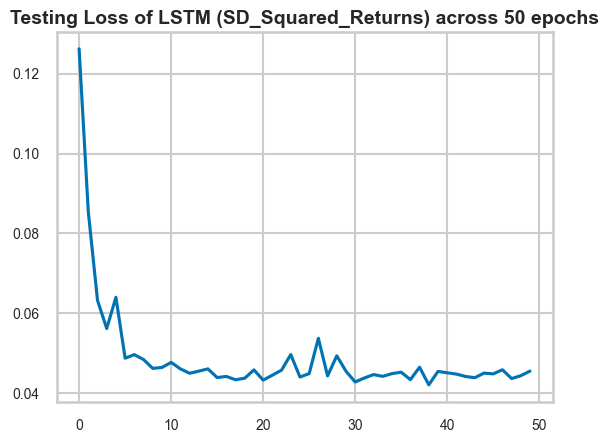

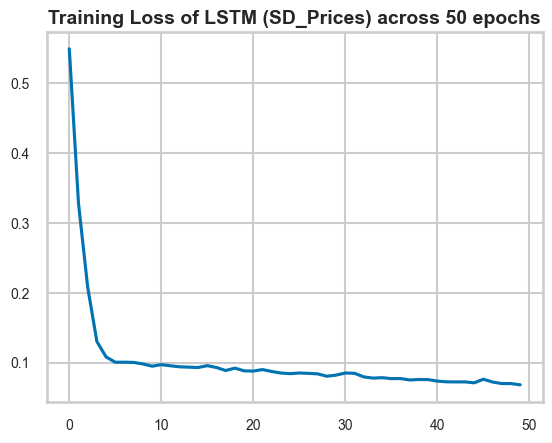

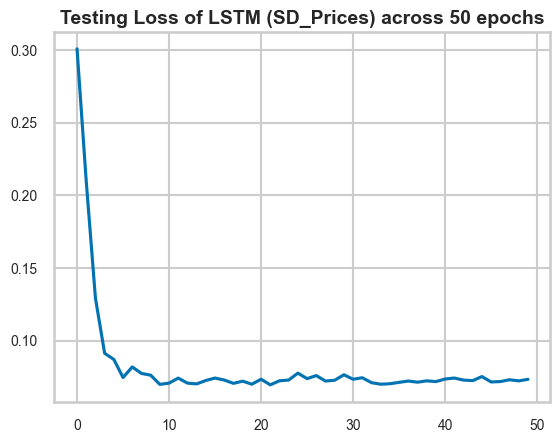

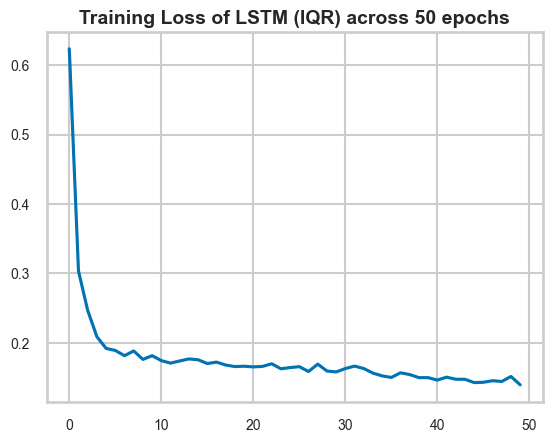

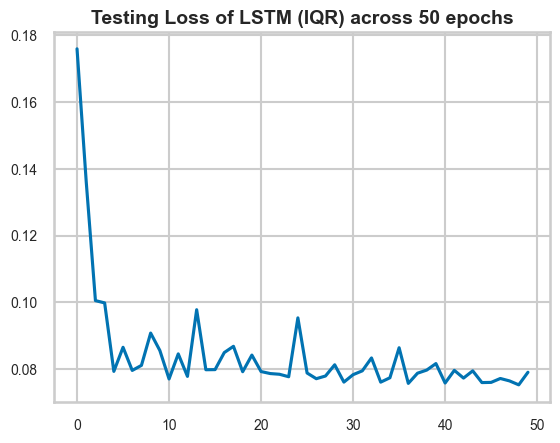

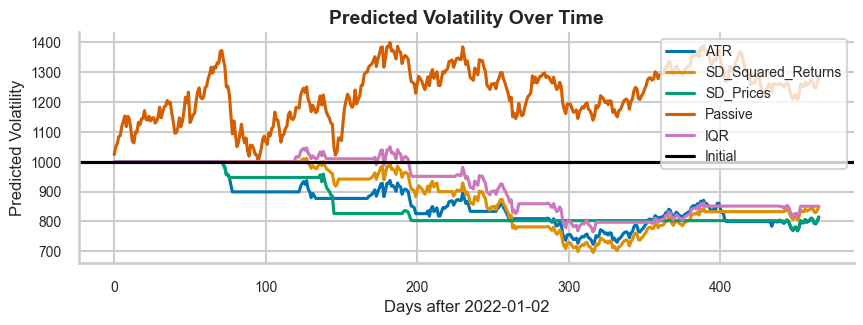

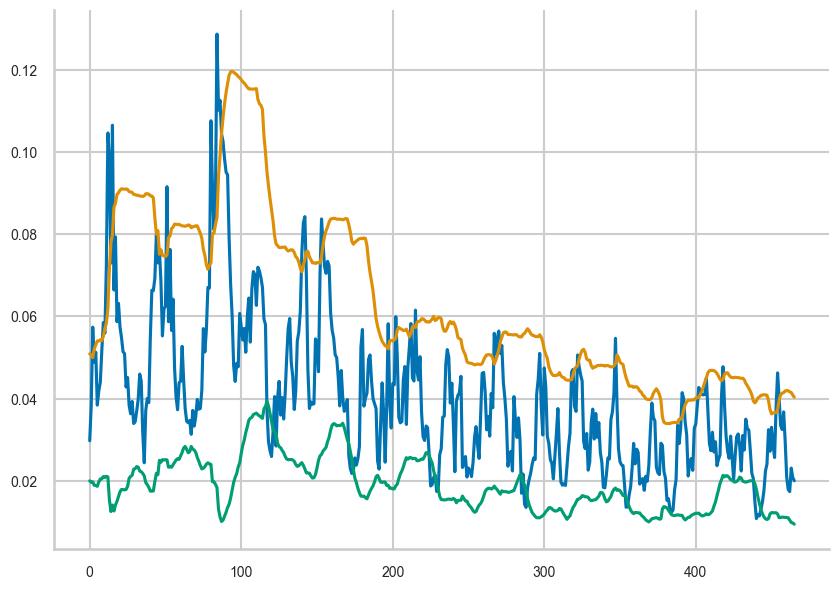

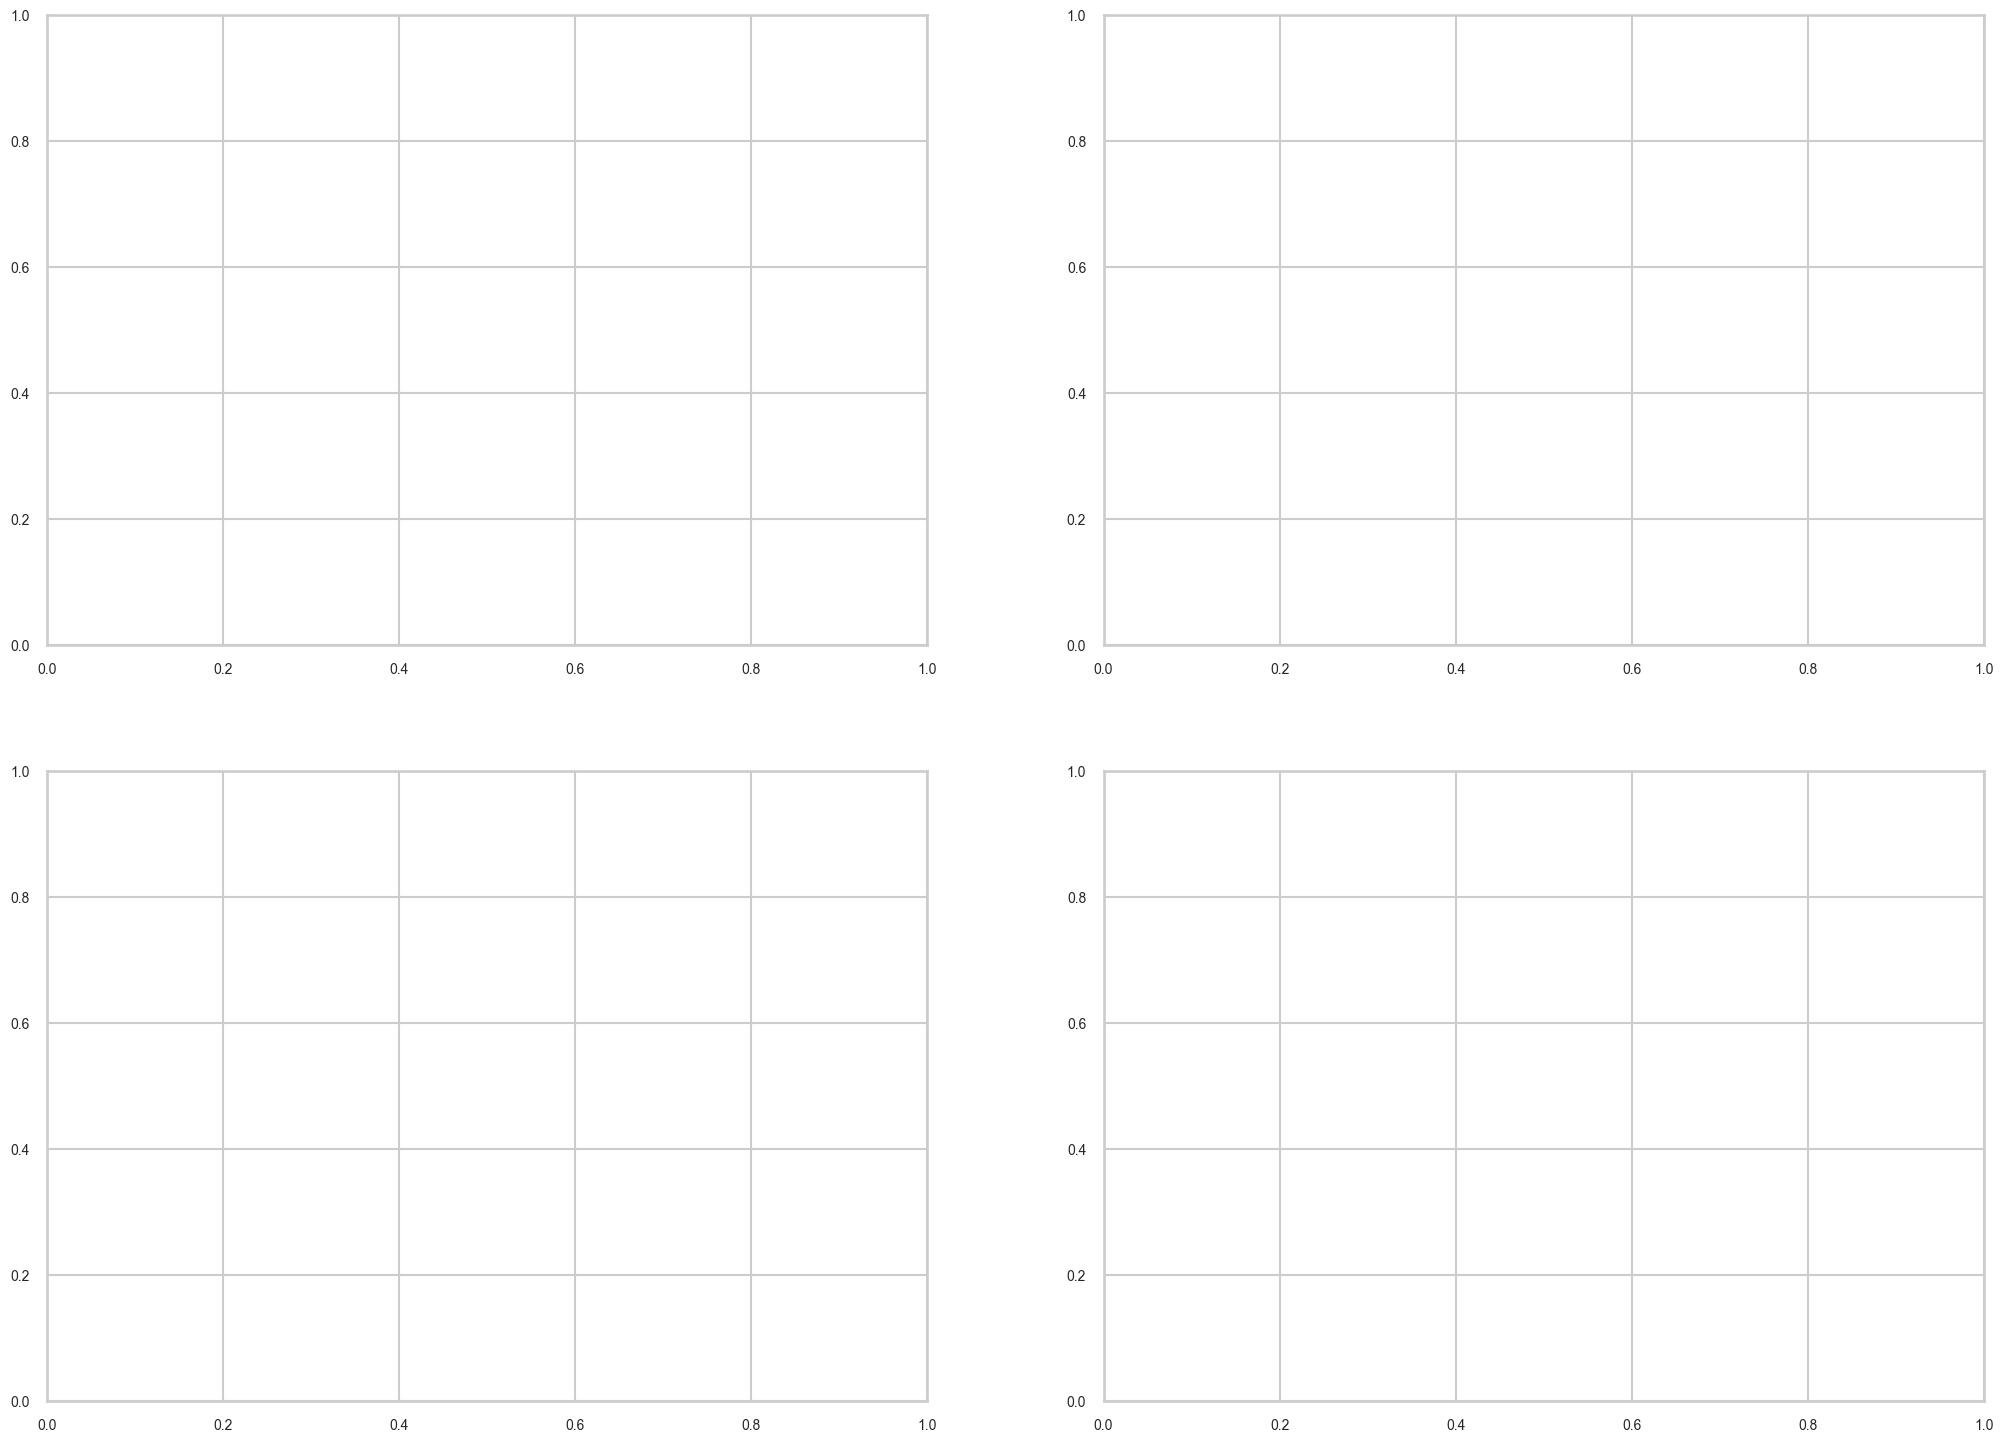

In [6]:
num=67676767
for file in os.listdir('../output'):
    if "runtest" in file:
        num+=1
os.mkdir(f'../output/runtest_{num}')
for d,(start,end,start_t,end_t) in enumerate(date_list):
    os.mkdir(f'../output/runtest_{num}/date_config{d}')
    for model_type in models:
        os.mkdir(f'../output/runtest_{num}/date_config{d}/{model_type}')
        root = f'../output/runtest_{num}/date_config{d}/{model_type}'
        with open(os.path.join(root,'run_data.txt'),'w') as f:
            f.write(f'Start Training Date: {start} \n End Training Date: {end} \n Start Sim Date: {start_t} \n End Sim Date: {end_t} \n')
            f.write(f'\n Model Type: {model_type}')
            f.write(f'Look-back window: {T} days')

        for etf in etfs:
            os.mkdir(f'{root}/{etf}')
        for lr in lrs:
            results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[],"Relative_MSE":[],"MAPE":[],"DM_stat":[],"DM_p":[]})
            money_df_std = pd.DataFrame()
            money_df_atr = pd.DataFrame()
            money_df_sd_prices = pd.DataFrame()
            money_df_iqr = pd.DataFrame()
            money_df_passive = pd.DataFrame()
            for j,etf in enumerate(etfs):
                #fig,ax = plt.subplots(1,len(metrics),figsize=(26,6))
                fig,ax = plt.subplots(2,2,figsize=(25,18))
                atr_preds = []
                for i,metric in enumerate(metrics):
                    scaler = StandardScaler()
                    scaler_x = StandardScaler()
                    df = get_cleaned_df(etf,start,end)
                    #print(df)
                    model,fig_tr,fig_te = get_trained_model(df,scaler, scaler_x, metric=metric,model_type=model_type)
                    fig_tr.savefig(os.path.join(root,etf,f'training_results_{metric}'))
                    fig_te.savefig(os.path.join(root,etf,f'testing_results_{metric}'))
                    df_test = get_cleaned_df(etf,start_t,end_t)
                    ini_cash = 10000
                    final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money, lowers, uppers, vols = backtest_strategy_mr(df_test,model,scaler,scaler_x,metric,sell_scale=1.7,buy_scale=1.7)
                    print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
                    
                    real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
                    atr_met = np.array(df_test["ATR"].iloc[T:len(df_test)-1])
                    null_model_error = np.sum((real_met-real_met.mean())**2)
                    mse_error = 1/len(real_met) * np.sum((real_met-preds)**2)/null_model_error
                    mape_error = 1/len(real_met) * np.sum(abs(real_met-preds)/(real_met+1e-8))
                    if metric=="ATR": #atr should go first
                        money_df_atr[etf] = t_money
                        atr_preds = preds
                    elif metric=="SD_Squared_Returns":
                        money_df_std[etf] = t_money
                        money_df_passive[f"{etf}_Passive"] = p_money
                    elif metric == "SD_Prices":
                        money_df_sd_prices[etf] = t_money
                    elif metric == "IQR":
                        money_df_iqr[etf] = t_money

                    dm,p = diebold_mariano_test(atr_met,atr_preds,real_met,preds,loss="mae")
                    results.loc[len(results)] = [etf,metric,final_value,passive_value,mse_error,mape_error,dm,p]

                    sns.lineplot(preds,ax=ax[i//2][i%2],label=f"Prediction {metric}",color="Blue",linestyle = '--')
                    sns.lineplot(real_met,ax=ax[i//2][i%2],label = f"True {metric}",color="Orange")
                    sns.despine(ax=ax[i//2][i%2])
                    #for buy in buy_points:
                        #ax[i].axvline(buy,color="Green",alpha=.6)
                    #for sell in sell_points:
                        #ax[i].axvline(sell,color="Red",alpha=.6)
                    ax[i//2][i%2].set_title(f"{etf} - {metric} ")
                    ax[i//2][i%2].set_xlabel(f'Total MSE Error {mse_error:.6f} | Total MAPE Error: {mape_error:.3f}')
                    customize_ax(ax[i//2][i%2])
                    #plt.title(f"Performance of LSTM on {etf}")
                fig.supylabel("Volatility Metric")
                fig.supxlabel(f"Days after {start_t}")
                fig.tight_layout()
                fig.savefig(os.path.join(root,etf,'predictions_lr_{lr}.png'))
                fig_sim,ax_sim = plt.subplots(figsize=(10,3))
                sns.lineplot(x=range(0, len(df_test.index)-(T+1)), y=money_df_atr[etf], label="ATR",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_std[etf],label="SD_Squared_Returns",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_sd_prices[etf],label="SD_Prices",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_passive[f"{etf}_Passive"],label="Passive",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_iqr[etf],label="IQR",ax=ax_sim)
                sns.despine(ax=ax_sim)
                ax_sim.axhline(1000, label = "Initial",color="Black")
                ax_sim.set_xlabel(f"Days after {start_t}")
                ax_sim.set_title(f"ETF Performance Over Time for {etf}")
                customize_ax(ax_sim)
                fig_sim.savefig(os.path.join(root,etf,'simulation_perf_lr_{lr}'))

                fig10, ax10 = plt.subplots(figsize = (10,7))
                sns.lineplot(x = range(0,len(df_test.index)-(T+1)), y = vols, ax = ax10)
                sns.lineplot(x = range(0,len(df_test.index)-(T+1)), y = uppers, ax = ax10)
                sns.lineplot(x = range(0,len(df_test.index)-(T+1)), y = lowers, ax = ax10)
                sns.despine(ax=ax10)
                ax10.set_xlabel(f"Days after {start_t}")
                ax10.set_ylabel("Predicted Volatility")
                ax10.set_title(f"Predicted Volatility Over Time")
                customize_ax(ax_sim)
                fig10.savefig(os.path.join(root,etf,'vol_over_time'))





                
            fig2,ax2 = plt.subplots(figsize = (8,6))
            sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax2) 
            sns.despine(ax=ax2)   
            plt.legend(loc=(1.1,1))
            fig2.tight_layout()
            customize_ax(ax2)
            fig2.savefig(os.path.join(root,'return_metrics_lr_{lr}.png'))
            results.to_csv(os.path.join(root,'overall_results.csv'),index=False)

In [ ]:
os.listdir()

In [ ]:
for i in range(32,41):
    df = pd.read_csv(f'runtest_{i}/overall_results.csv')
    print(i,df.groupby('Metric')['Relative_MSE'].mean())

In [ ]:
scaler_x = StandardScaler()
scaler = StandardScaler()
start,end,start_t,end_t = date_list[1]
df_xlp = get_cleaned_df('XLP',start,end)
df_xlp_test = get_cleaned_df('XLP',start_t,end_t)
model,fig_tr,fig_te = get_trained_model(df_xlp,scaler, scaler_x, metric="SD_Squared_Returns",model_type="LSTM")
final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money = backtest_strategy_mr(df_xlp_test,model,scaler,scaler_x,"SD_Squared_Returns",sell_scale=1.7,buy_scale=1.7)

In [ ]:
sns.lineplot(t_money)